# Analyse Exploiratoire de Données

### 🎯 **Objectif** :

Prédire le **prix de vente** des plaques d’immatriculation russes à partir de données d’annonces collectées entre 2021 et 2025.

---

### 🔤 **Format des plaques** :

* Trois lettres (alphabet cyrillique restreint : ABEKMHOPCTYX)
* Trois chiffres (excluant 000)
* Code de région

---

### 📊 **Particularités** :

* Une plaque peut apparaître plusieurs fois (avec des prix différents)
* Certaines plaques ont des **valeurs symboliques/gouvernementales**
* Des **champs textuels + temporels** à exploiter
* Les données viennent de **sites, Telegram, agrégateurs** ⇒ bruit potentiel à nettoyer

---

#### Colonne plate, extraire automatiquement :
- Le code de région (**region_code**)
- Le nom de la région (**region_name**)
- Si la plaque est gouvernementale (**is_gov_plate**)
- Si la plaque donne un avantage routier (**has_road_advantage**)
- Le niveau d’importance attribué à la plaque (**gov_importance_level**)

---

### 📈 **Évaluation** :

**SMAPE** : Symmetric Mean Absolute Percentage Error
→ Plus le score est **faible**, mieux c’est.

---

### 🏆 **Prix** :

* 1ère place : 25\$
* 2e : 15\$
* 3e : 10\$

In [4]:
# Importation des libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Chargement des données
data_path = Path("C:/Users/Optimiste/Videos/Concours/Prédiction_prix_plaques_russes/data")
train = pd.read_csv(data_path / "train_plate.csv")
test = pd.read_csv(data_path / "test_plate.csv")
sample_submission = pd.read_csv(data_path / "sample_submission.csv")

# Aperçu
print(train.shape)
print(train.head())


(51635, 11)
   id      plate                 date   price letters  digits  region_code  \
0   1  X059CP797  2024-12-26 00:00:00   65000     XCP      59          797   
1   2  Y800MH790  2024-07-12 21:31:37  100000     YMH     800          790   
2   3   A212TX77  2024-04-18 00:00:00  290000     ATX     212           77   
3   4  P001AY199  2025-01-03 00:27:15  680000     PAY       1          199   
4   5  P001AY199  2025-01-10 09:32:41  750000     PAY       1          199   

     region_name  is_gov_plate  has_road_advantage  gov_importance_level  
0         Moscow             0                   0                     0  
1  Moscow Oblast             0                   0                     0  
2         Moscow             0                   0                     0  
3         Moscow             0                   0                     0  
4         Moscow             0                   0                     0  


| ✅ Colonne              | 📖 Description                              |
| ---------------------- | ------------------------------------------- |
| `letters`              | Lettres extraites de la plaque              |
| `digits`               | Chiffres extraits                           |
| `region_code`          | Code numérique de la région (**corrigé !**) |
| `region_name`          | Nom officiel de la région                   |
| `is_gov_plate`         | 1 si plaque gouvernementale                 |
| `has_road_advantage`   | 1 si plaque prioritaire                     |
| `gov_importance_level` | Niveau d’importance gouvernementale         |
| `price`, `date`        | Cibles et variables temporelles             |


### 1. Aperçu

In [7]:
train.dtypes

id                       int64
plate                   object
date                    object
price                    int64
letters                 object
digits                   int64
region_code              int64
region_name             object
is_gov_plate             int64
has_road_advantage       int64
gov_importance_level     int64
dtype: object

In [9]:
train.region_name.describe()

count      51635
unique        88
top       Moscow
freq       25479
Name: region_name, dtype: object

In [11]:
train.price.describe()

count    5.163500e+04
mean     4.532253e+05
std      1.793287e+06
min      2.000000e+04
25%      7.000000e+04
50%      1.500000e+05
75%      3.600000e+05
max      1.000000e+08
Name: price, dtype: float64

In [13]:
train.region_name.unique()

array(['Moscow', 'Moscow Oblast', 'Republic of Dagestan',
       'Irkutsk Oblast', 'Volgograd Oblast', 'Sverdlovsk Oblast',
       'Krasnodar Krai', 'Saint Petersburg', 'Zabaykalsky Krai',
       'Kaluga Oblast', 'Kirov Oblast', 'Chechen Republic',
       'Yamalo-Nenets Autonomous Okrug', 'Kaliningrad Oblast',
       'Krasnoyarsk Krai', 'Vladimir Oblast', 'Amur Oblast',
       'Chelyabinsk Oblast', 'Rostov Oblast', 'Altai Krai',
       'Udmurt Republic', 'Pskov Oblast', 'Samara Oblast',
       'Bryansk Oblast', 'Republic of Tatarstan', 'Stavropol Krai',
       'Tver Oblast', 'Belgorod Oblast', 'Kursk Oblast',
       'Republic of Crimea', 'Kemerovo Oblast', 'Ulyanovsk Oblast',
       'Khanty-Mansi Autonomous Okrug', 'Novosibirsk Oblast',
       'Omsk Oblast', 'Komi Republic', 'Nizhny Novgorod Oblast',
       'Kamchatka Krai', 'Tambov Oblast', 'Khabarovsk Krai',
       'Astrakhan Oblast', 'Saratov Oblast', 'Leningrad Oblast',
       'Tyumen Oblast', 'Republic of Ingushetia', 'Primorsky K

In [15]:
train.region_name.value_counts()

region_name
Moscow                       25479
Moscow Oblast                12927
Krasnodar Krai                1417
Saint Petersburg               938
Republic of Dagestan           627
                             ...  
Chukotka Autonomous Okrug        9
Nenets Autonomous Okrug          4
Donetsk People's Republic        4
Baikonur                         2
Luhansk People's Republic        1
Name: count, Length: 88, dtype: int64

In [17]:
# Conversion des dates
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

---
### 2. Analyse des Prix des plaques

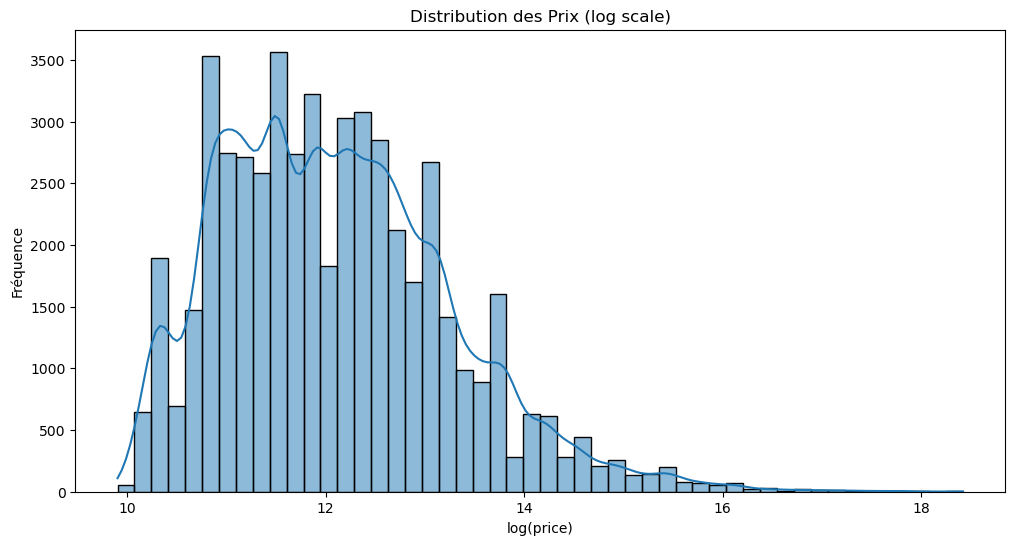

In [21]:
# Distribution des Prix (Échelle Log)

plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(train['price']), bins=50, kde=True)
plt.title('Distribution des Prix (log scale)')
plt.xlabel('log(price)')
plt.ylabel('Fréquence')
plt.show()

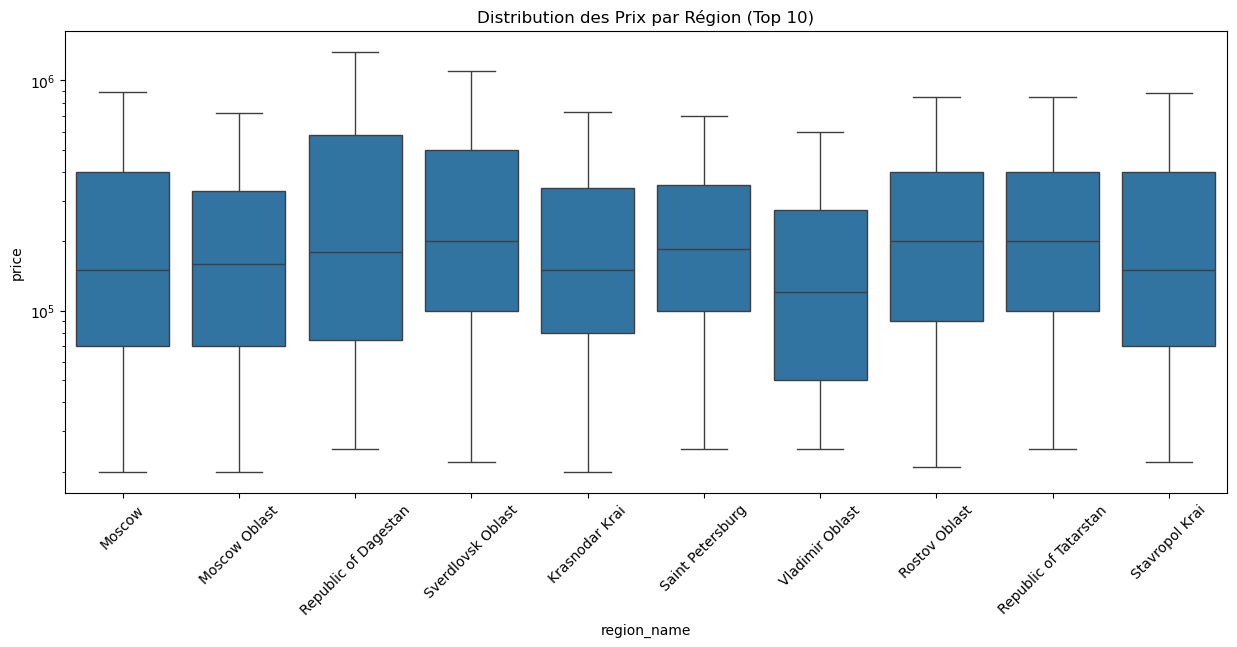

In [23]:
# Boxplot par région (Top 10)
top_regions = train['region_name'].value_counts().head(10).index
plt.figure(figsize=(15, 6))
sns.boxplot(
    x='region_name',
    y='price',
    data=train[train['region_name'].isin(top_regions)],
    showfliers=False
)
plt.yscale('log')
plt.title('Distribution des Prix par Région (Top 10)')
plt.xticks(rotation=45)
plt.show()

---
### 3. Analyse des Plaques Gouvernementales 

Statistiques par statut gouvernemental :
                      mean     median  count
is_gov_plate                                
0             4.259085e+05   150000.0  50973
1             2.556577e+06  1025000.0    662


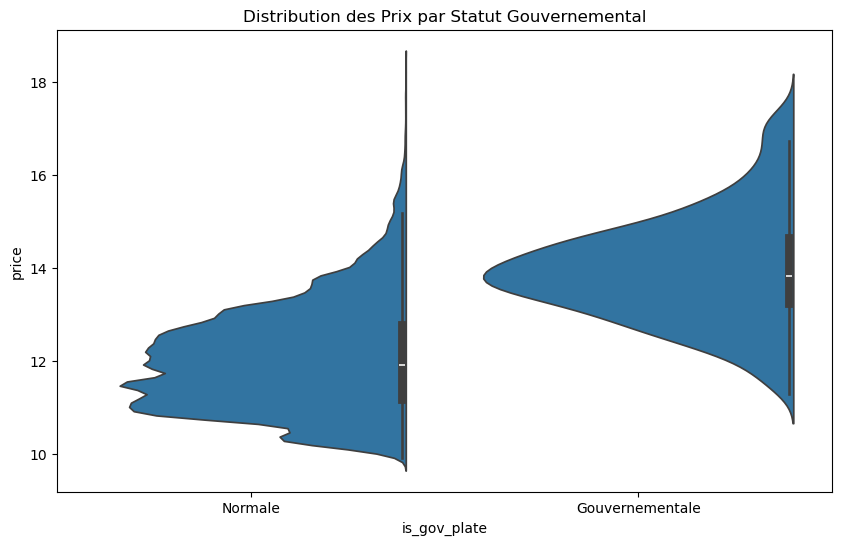

In [26]:
# Impact sur les Prix

gov_stats = train.groupby('is_gov_plate')['price'].agg(['mean', 'median', 'count'])
print("Statistiques par statut gouvernemental :")
print(gov_stats)

plt.figure(figsize=(10, 6))
sns.violinplot(
    x='is_gov_plate',
    y=np.log1p(train['price']),
    data=train,
    split=True
)
plt.title('Distribution des Prix par Statut Gouvernemental')
plt.xticks([0, 1], ['Normale', 'Gouvernementale'])
plt.show()

➡️ Les plaques gouvernementales sont en moyenne 6 fois plus chères.

➡️ Médiane > 1 million € = fort signal d'identification.

---
### 4. Analye temporelle

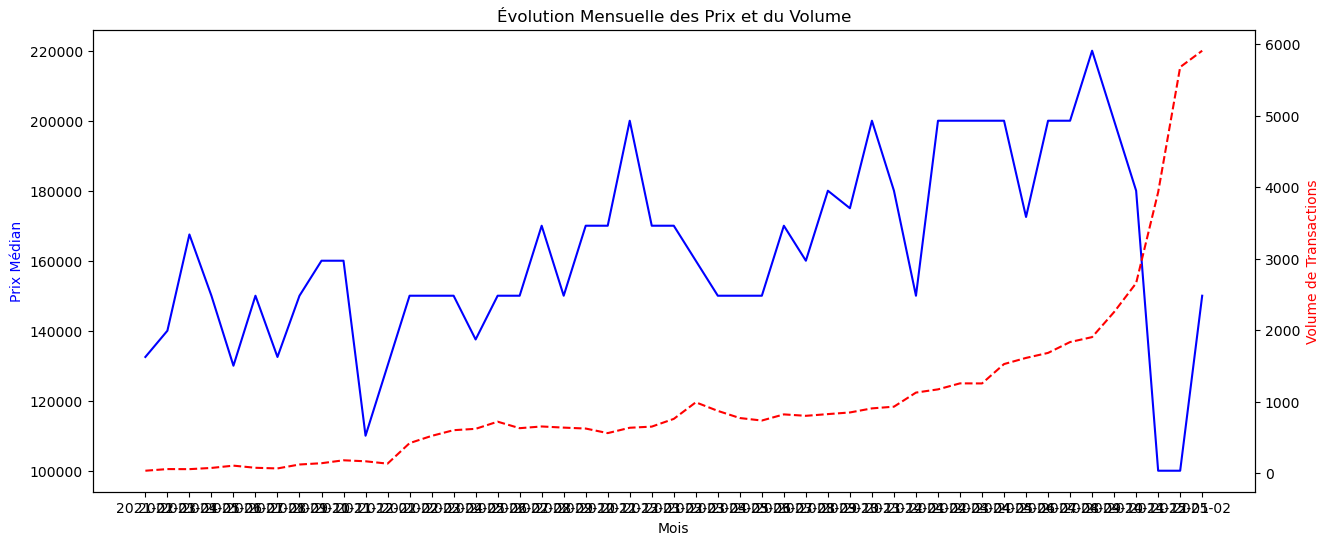

In [29]:

## Tendances Mensuelles

train['month'] = train['date'].dt.to_period('M')
monthly_stats = train.groupby('month').agg({
    'price': 'median',
    'id': 'count'
}).rename(columns={'id': 'volume'})

fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

ax1.plot(monthly_stats.index.astype(str), monthly_stats['price'], 'b-')
ax2.plot(monthly_stats.index.astype(str), monthly_stats['volume'], 'r--')

ax1.set_xlabel('Mois')
ax1.set_ylabel('Prix Médian', color='b')
ax2.set_ylabel('Volume de Transactions', color='r')
plt.title('Évolution Mensuelle des Prix et du Volume')
plt.xticks(rotation=45)
plt.show()

---
### 5. Analyse des Combinaisons de Lettres/Chiffres

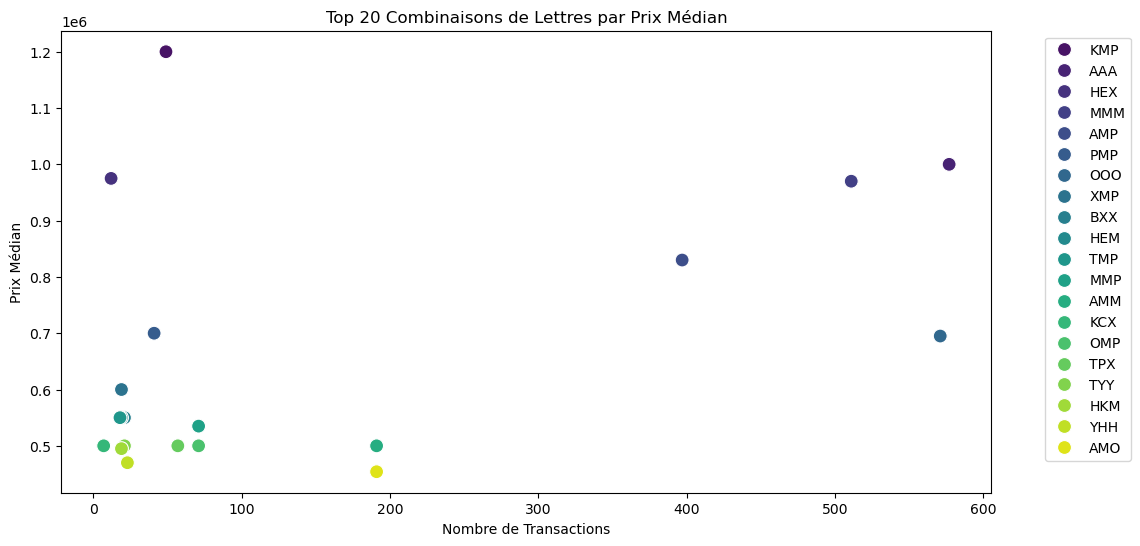


Prix médian - Chiffres magiques vs normaux :
is_magic
0    130000.0
1    420000.0
Name: price, dtype: float64


In [32]:

##Lettres les Plus Valeureuses

top_letters = train.groupby('letters').agg({
    'price': 'median',
    'id': 'count'
}).nlargest(20, 'price')

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=top_letters['id'],
    y=top_letters['price'],
    hue=top_letters.index,
    s=100,
    palette='viridis'
)
plt.title('Top 20 Combinaisons de Lettres par Prix Médian')
plt.xlabel('Nombre de Transactions')
plt.ylabel('Prix Médian')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Chiffres "Magiques"
magic_numbers = [111, 222, 333, 444, 555, 666, 777, 888, 999]
train['is_magic'] = train['digits'].isin(magic_numbers).astype(int)

magic_stats = train.groupby('is_magic')['price'].median()
print("\nPrix médian - Chiffres magiques vs normaux :")
print(magic_stats)

➡️ Les plaques avec chiffres spéciaux (genre 777, 888) sont plus de 3x plus chères.
- C'est un excellent feature prédictif.

---
### 6. Corrélations clés

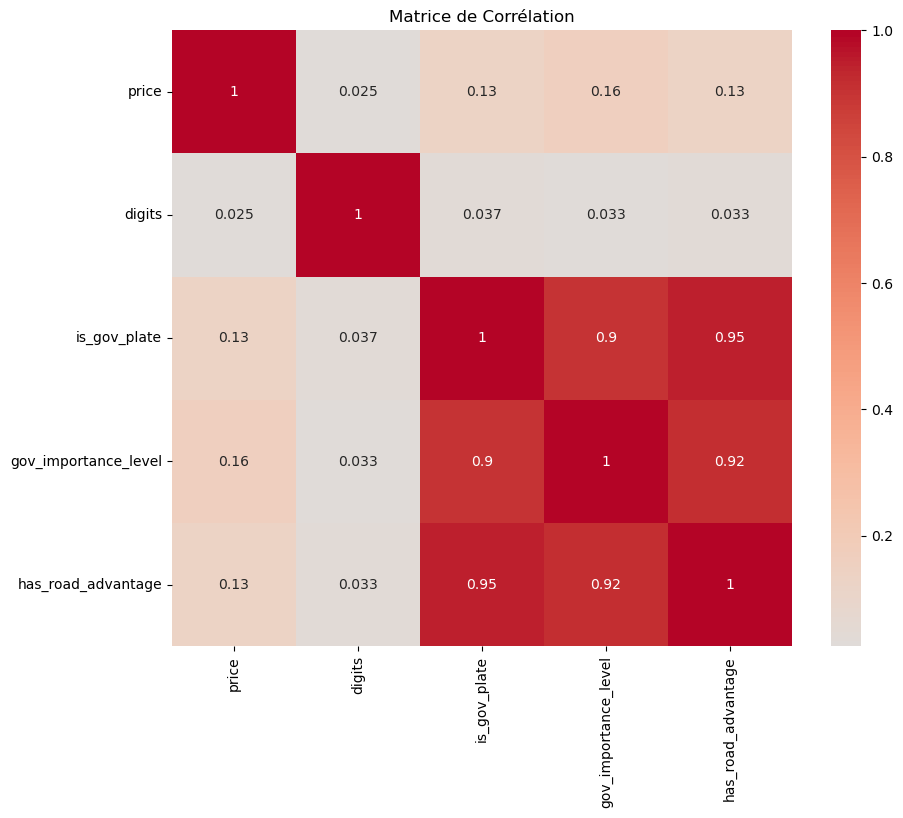

In [36]:
# Matrice de Corrélation
corr_matrix = train[[
    'price',
    'digits',
    'is_gov_plate',
    'gov_importance_level',
    'has_road_advantage'
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation')
plt.show()

In [38]:
corr_matrix

,price,digits,is_gov_plate,gov_importance_level,has_road_advantage
price,1.000000,0.025174,0.133667,0.160626,0.131139
digits,0.025174,1.000000,0.037245,0.032620,0.033087
is_gov_plate,0.133667,0.037245,1.000000,0.902900,0.949837
gov_importance_level,0.160626,0.032620,0.902900,1.000000,0.918377
has_road_advantage,0.131139,0.033087,0.949837,0.918377,1.000000


➡️ Les variables gouvernementales sont les plus corrélées avec le prix

➡️ digits (chiffres) a un effet plus faible, mais combiné à is_magic, ça se renforce.

---
### 7. Détection des valeurs extrêmes

In [43]:
# Analyse des Outliers
Q1 = train['price'].quantile(0.25)
Q3 = train['price'].quantile(0.75)
IQR = Q3 - Q1

outliers = train[(train['price'] < (Q1 - 1.5 * IQR)) | (train['price'] > (Q3 + 1.5 * IQR))]
print(f"\nNombre d'outliers prix : {len(outliers)} ({len(outliers)/len(train):.2%})")

# Inspection des outliers hauts
high_outliers = outliers.nlargest(10, 'price')
print("\nTop 10 outliers :")
print(high_outliers[['plate', 'price', 'region_name', 'is_gov_plate', 'gov_importance_level']])


Nombre d'outliers prix : 5601 (10.85%)

Top 10 outliers :
           plate      price           region_name  is_gov_plate  \
1794   K252KK777  100000000                Moscow             0   
21108   M026MM08  100000000  Republic of Kalmykia             0   
43878   B777CY77  100000000                Moscow             0   
47081   X777XX05  100000000  Republic of Dagestan             0   
41264   O039CA39   75000000    Kaliningrad Oblast             0   
47086  Y293TY193   70000000        Krasnodar Krai             0   
14331   A777YX77   65000000                Moscow             0   
22175   B888OP88   55000500      Krasnoyarsk Krai             0   
14334   A777YX77   55000000                Moscow             0   
335     E007XA77   50000000                Moscow             0   

       gov_importance_level  
1794                      0  
21108                     0  
43878                     0  
47081                     0  
41264                     0  
47086                  

- 5 601 outliers, soit 10.85 % des données.
- 10 premières plaques : entre 50 et 100 millions €, toutes non-gouvernementales ❗

In [53]:
# Sauvegarder la version enrichie du jeu d'entraînement et de test
train.to_csv(data_path /"train_eda.csv", index=False)
test.to_csv(data_path /"test_eda.csv", index=False)
